In [1]:
"""
testing the simple heuristics Personalized PageRank (PPR), Adamic Adar (AA) and Common Neighbours (CN)

This is the directed test graph
   -> 0 -> 1 <-
   |          |
    --- 2 <---
"""
import unittest
import math

import torch
from torch import tensor
import scipy.sparse as ssp
import numpy as np

#from heuristics import AA, PPR, CN, RA

In [24]:
edge_index = tensor([[0, 2, 2, 1], [1, 0, 1, 2]]).t()
edge_weight = torch.ones(edge_index.size(0), dtype=torch.int)
test_edges = tensor([[0, 1], [1, 2]]).t()
num_nodes = 3
A = ssp.csr_matrix((edge_weight, (edge_index[:, 0], edge_index[:, 1])),
                        shape=(num_nodes, num_nodes))#, dtype=np.float)
neg_test_edges = tensor([[0, 1], [2, 0]]).t()
print('1. Edge Index = \n %s' % edge_index, '2. Edge weight = %s' % edge_weight, sep='\n')
print('3. Test Edges = \n %s' % test_edges, '4. Adjacency Matrix = \n %s' % A, sep='\n')
print('5. Negative Test Edges =\n %s' % neg_test_edges)


1. Edge Index = 
 tensor([[0, 1],
        [2, 0],
        [2, 1],
        [1, 2]])
2. Edge weight = tensor([1, 1, 1, 1], dtype=torch.int32)
3. Test Edges = 
 tensor([[0, 1],
        [1, 2]])
4. Adjacency Matrix = 
   (0, 1)	1
  (1, 2)	1
  (2, 0)	1
  (2, 1)	1
5. Negative Test Edges =
 tensor([[0, 2],
        [1, 0]])


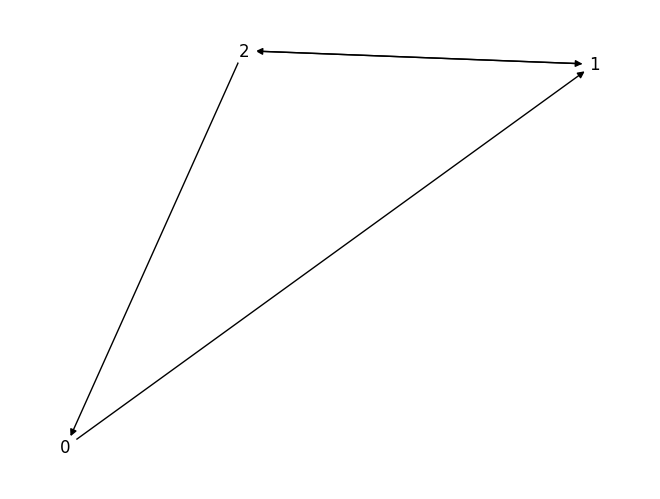

In [11]:
import networkx as nx
G = nx.DiGraph()
G.add_edges_from(edge_index.numpy())
nx.draw(G, with_labels=True, node_color='white')

In [48]:
# create a graph with 2 isomorphic nodes 2 & 3
iso_edge_index = tensor([[2, 2, 3, 3, 4, 0], [1, 4, 1, 4, 0, 1]]).t()
iso_edge_weight = torch.ones(iso_edge_index.size(0), dtype=int)
iso_test_edges = tensor([[2, 3], [0, 0]]).t()
iso_num_nodes = 5

square1 = np.array([[0, 1, 1, 2, 2, 3, 3, 0],
                    [1, 0, 2, 1, 3, 2, 0, 3]])
square2 = square1 + 4
bridge = np.array([[0, 4],
                    [4, 0]])

common_neigbours = np.array([[0, 9, 9, 4, 0, 8, 4, 8],
                                [9, 0, 4, 9, 8, 0, 8, 4]])

ei = torch.tensor(np.concatenate([square1, square2, bridge, common_neigbours], axis=1), dtype=torch.long)
ew = torch.ones(ei.size(1), dtype=int)
num_nodes = 10
A1 = ssp.csr_matrix((ew, (ei[0], ei[1])), shape=(num_nodes, num_nodes))
# print(ei, ew, A1, sep='\n')

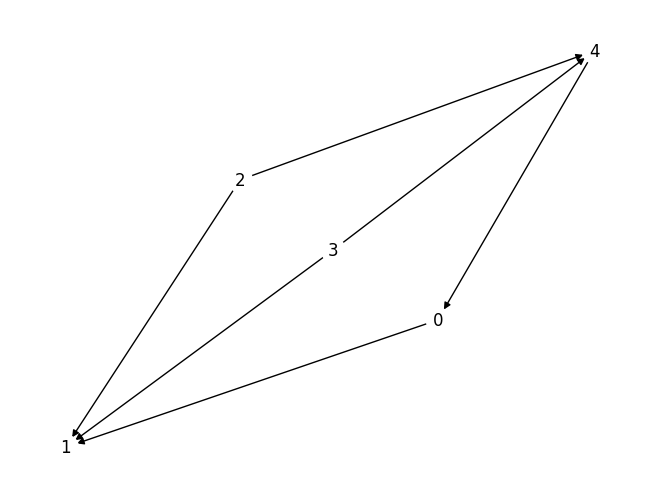

In [62]:
import networkx as nx
iso_G = nx.DiGraph()  ## [2, 2, 3, 3, 4, 0], [1, 4, 1, 4, 0, 1]
iso_G.add_edges_from(iso_edge_index.numpy())
nx.draw(iso_G, with_labels=True, node_color='white')

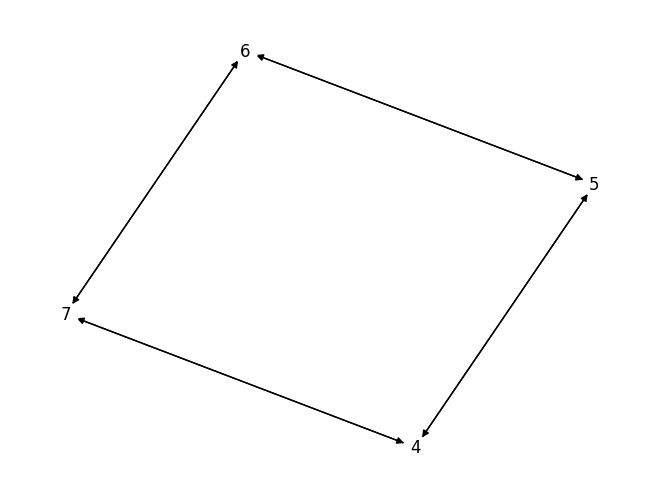

In [46]:
square_G = nx.DiGraph()
square_G.add_edges_from(tensor(square2).t().numpy())
nx.draw(square_G, with_labels=True, node_color='white')

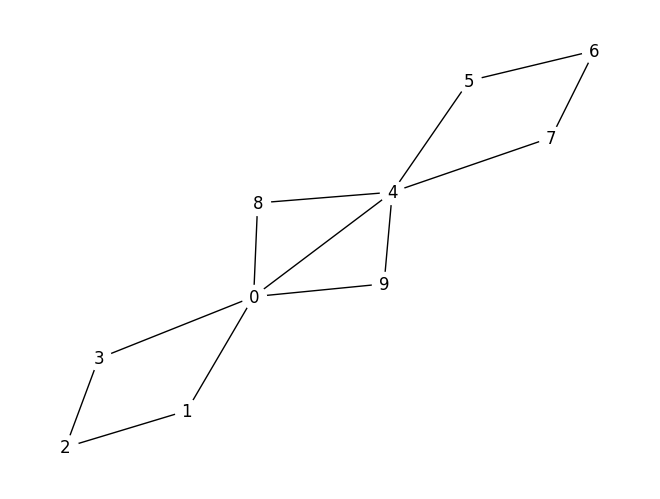

In [80]:
import networkx as nx
G1 = nx.from_numpy_array(A1.todense())#toarray())
nx.draw(G1, with_labels=True, node_color='white')

### CN (common neighbors) : $f_{CN}(x,y)=|\Gamma(x)\cap\Gamma(y)|$  
### AA (Adamic-Adar) : $f_{AA}(x,y)=\sum_{z\in\Gamma(x)\cap\Gamma(y)}\frac{1}{\log|\Gamma(z)|}$  
### RA (Resource allocation) : $f_{RA}(x,y)=\sum_{z\in\Gamma(x)\cap\Gamma(y)}\frac{1}{|\Gamma(z)|}$  
  
![Untitled](https://github.com/helloliz-korea/recommender/assets/76797423/c35db018-91e2-49f9-b9d5-cd77872973f7)

In [67]:
"""
A selection of heuristic methods (Personalized PageRank, Adamic Adar and Common Neighbours) for link prediction
"""

import numpy as np
from tqdm import tqdm
import torch
from torch_geometric.loader import DataLoader

In [155]:
## 아래 CN_에 나오는 스코어 계산 확인
mat_A = A.todense()
for i in range(edge_index.size(0)):
    src, dst = edge_index[i, 0], edge_index[i, 1]
    print(src, dst)
    print(mat_A[src], mat_A[dst], sep='\n')
    cur_scores = np.array(np.sum(A[src].multiply(A[dst]), 1)).flatten()
    print(A[src].multiply(A[dst]), cur_scores)
    print((mat_A[src] @ mat_A[dst].T))

tensor(0) tensor(1)
[[0 1 0]]
[[0 0 1]]
 [0]
[[0]]
tensor(2) tensor(0)
[[1 1 0]]
[[0 1 0]]
  (0, 1)	1 [1]
[[1]]
tensor(2) tensor(1)
[[1 1 0]]
[[0 0 1]]
 [0]
[[0]]
tensor(1) tensor(2)
[[0 0 1]]
[[1 1 0]]
 [0]
[[0]]


In [75]:
def CN(A, edge_index, batch_size=100000):
    """
    Common neighbours
    :param A: scipy sparse adjacency matrix
    :param edge_index: pyg edge_index
    :param batch_size: int
    :return: FloatTensor [edges] of scores, pyg edge_index
    """
    link_loader = DataLoader(range(edge_index.size(0)), batch_size)
    scores = []
    for ind in tqdm(link_loader):
        src, dst = edge_index[ind, 0], edge_index[ind, 1]
        cur_scores = np.array(np.sum(A[src].multiply(A[dst]), 1)).flatten()
        scores.append(cur_scores)
    scores = np.concatenate(scores, 0)
    print(f'evaluated Common Neighbours for {len(scores)} edges')
    return torch.FloatTensor(scores), edge_index

sample_scores, sample_index = CN(A, edge_index)

100%|██████████| 1/1 [00:00<00:00, 459.55it/s]

evaluated Common Neighbours for 4 edges


In [76]:
print("학습 점수:\n{}".format(sample_scores))

학습 점수:
tensor([0., 1., 0., 0.])


In [63]:
def test_CN(A, edge_index, neg_test_edges, test_edges):
    train_scores, edge_index = CN(A, edge_index)
    t1 = np.array_equal(train_scores, np.array([0, 1, 0, 0])) 
    neg_scores, edge_index = CN(A, neg_test_edges)
    t2 = np.array_equal(neg_scores, np.array([1, 0]))
    pos_scores, edge_index = CN(A, test_edges)
    t3 = np.array_equal(pos_scores, np.array([0, 0]))
    return t1, t2, t3

def test_AA(A, edge_index, neg_test_edges, test_edges):
    train_scores, edge_index = AA(A, edge_index)
    print(train_scores)
    a1 = np.allclose(train_scores, np.array([0, 1 / math.log(2), 0, 0]))
    neg_scores, edge_index = AA(A, neg_test_edges)
    a2 = np.allclose(neg_scores, np.array([1 / math.log(2), 0]))
    pos_scores, edge_index = AA(A, test_edges)
    a3 = np.allclose(pos_scores, np.array([0, 0]))
    return a1, a2, a3

def test_RA(A, edge_index, neg_test_edges, test_edges):
    train_scores, edge_index = RA(A, edge_index)
    print(train_scores)
    r1 = np.allclose(train_scores, np.array([0, 1 / 2, 0, 0]))
    neg_scores, edge_index = RA(A, neg_test_edges)
    r2 = np.allclose(neg_scores, np.array([1 / 2, 0]))
    pos_scores, edge_index = RA(A, test_edges)
    r3 = np.allclose(pos_scores, np.array([0, 0]))
    return r1, r2, r3

def test_iso_graph(A, iso_edge_weight, iso_edge_index, iso_num_nodes):
    A = ssp.csr_matrix((iso_edge_weight, (iso_edge_index[:, 0], iso_edge_index[:, 1])),
                        shape=(iso_num_nodes, iso_num_nodes))
    aa_test_scores, edge_index = AA(A, iso_test_edges)
    print(aa_test_scores)
    s1 = np.array_equal(aa_test_scores[0], aa_test_scores[1])
    cn_test_scores, edge_index = CN(A, iso_test_edges)
    print(cn_test_scores)
    s2 = np.array_equal(cn_test_scores[0], cn_test_scores[1])
    ppr_test_scores, edge_index = PPR(A, iso_test_edges)
    print(ppr_test_scores)
    s3 = np.array_equal(ppr_test_scores[0], ppr_test_scores[1])
    return s1, s2, s3

In [65]:
t_CN = test_CN(A, edge_index, neg_test_edges, test_edges)
t_AA = test_AA(A, edge_index, neg_test_edges, test_edges)
t_RA = test_RA(A, edge_index, neg_test_edges, test_edges)
t_iso = test_iso_graph(A, iso_edge_weight, iso_edge_index, iso_num_nodes)
print(t_CN, '------------------', t_AA, '------------------', t_RA, '------------------', t_iso, sep='\n')

100%|██████████| 1/1 [00:00<00:00, 435.50it/s]


evaluated Common Neighbours for 4 edges


100%|██████████| 1/1 [00:00<00:00, 559.24it/s]


evaluated Common Neighbours for 2 edges


100%|██████████| 1/1 [00:00<00:00, 413.39it/s]
/Users/yoonjeongyang/Desktop/subgraph-sketching-main/src/runners/heuristics.py:38: RuntimeWarning: divide by zero encountered in divide
  multiplier = 1 / np.log(A.sum(axis=0))


evaluated Common Neighbours for 2 edges


100%|██████████| 1/1 [00:00<00:00, 399.34it/s]


evaluated Adamic Adar for 4 edges
tensor([0.0000, 1.4427, 0.0000, 0.0000])


100%|██████████| 1/1 [00:00<00:00, 488.79it/s]


evaluated Adamic Adar for 2 edges


100%|██████████| 1/1 [00:00<00:00, 265.26it/s]


evaluated Adamic Adar for 2 edges


100%|██████████| 1/1 [00:00<00:00, 543.80it/s]


evaluated Resource Allocation for 4 edges
tensor([0.0000, 0.5000, 0.0000, 0.0000])


100%|██████████| 1/1 [00:00<00:00, 377.25it/s]


evaluated Resource Allocation for 2 edges


100%|██████████| 1/1 [00:00<00:00, 366.19it/s]
/Users/yoonjeongyang/Desktop/subgraph-sketching-main/src/runners/heuristics.py:38: RuntimeWarning: divide by zero encountered in log
  multiplier = 1 / np.log(A.sum(axis=0))


evaluated Resource Allocation for 2 edges


100%|██████████| 1/1 [00:00<00:00, 433.25it/s]


evaluated Adamic Adar for 2 edges
tensor([0.9102, 0.9102])


100%|██████████| 1/1 [00:00<00:00, 795.58it/s]


evaluated Common Neighbours for 2 edges
tensor([1., 1.])


100%|██████████| 2/2 [00:00<00:00, 397.70it/s]

evaluated PPR for 2 edges
tensor([0.1434, 0.1434])
(True, True, True)
------------------
(True, True, True)
------------------
(True, True, True)
------------------
(True, True, True)


In [ ]:
# class HeuristicTests(unittest.TestCase):
#     def setUp(self):
#         self.edge_index = tensor([[0, 2, 2, 1], [1, 0, 1, 2]]).t()
#         self.edge_weight = torch.ones(self.edge_index.size(0), dtype=torch.int)
#         self.test_edges = tensor([[0, 1], [1, 2]]).t()
#         self.num_nodes = 3
#         self.neg_test_edges = tensor([[0, 1], [2, 0]]).t()
#         self.A = ssp.csr_matrix((self.edge_weight, (self.edge_index[:, 0], self.edge_index[:, 1])),
#                                 shape=(self.num_nodes, self.num_nodes), dtype=np.float)
#         # create a graph with 2 isomorphic nodes 2 & 3
#         self.iso_edge_index = tensor([[2, 2, 3, 3, 4, 0], [1, 4, 1, 4, 0, 1]]).t()
#         self.iso_edge_weight = torch.ones(self.iso_edge_index.size(0), dtype=int)
#         self.iso_test_edges = tensor([[2, 3], [0, 0]]).t()
#         self.iso_num_nodes = 5

#         square1 = np.array([[0, 1, 1, 2, 2, 3, 3, 0],
#                             [1, 0, 2, 1, 3, 2, 0, 3]])
#         square2 = square1 + 4
#         bridge = np.array([[0, 4],
#                            [4, 0]])

#         common_neigbours = np.array([[0, 9, 9, 4, 0, 8, 4, 8],
#                                      [9, 0, 4, 9, 8, 0, 8, 4]])

#         self.ei = torch.tensor(np.concatenate([square1, square2, bridge, common_neigbours], axis=1), dtype=torch.long)
#         ew = torch.ones(self.ei.size(1), dtype=int)
#         num_nodes = 10
#         self.A1 = ssp.csr_matrix((ew, (self.ei[0], self.ei[1])), shape=(num_nodes, num_nodes))

#     def test_CN(self):
#         train_scores, edge_index = CN(self.A, self.edge_index)
#         self.assertTrue(np.array_equal(train_scores, np.array([0, 1, 0, 0])))
#         neg_scores, edge_index = CN(self.A, self.neg_test_edges)
#         self.assertTrue(np.array_equal(neg_scores, np.array([1, 0])))
#         pos_scores, edge_index = CN(self.A, self.test_edges)
#         self.assertTrue(np.array_equal(pos_scores, np.array([0, 0])))

#     def test_AA(self):
#         train_scores, edge_index = AA(self.A, self.edge_index)
#         print(train_scores)
#         self.assertTrue(np.allclose(train_scores, np.array([0, 1 / math.log(2), 0, 0])))
#         neg_scores, edge_index = AA(self.A, self.neg_test_edges)
#         self.assertTrue(np.allclose(neg_scores, np.array([1 / math.log(2), 0])))
#         pos_scores, edge_index = AA(self.A, self.test_edges)
#         self.assertTrue(np.allclose(pos_scores, np.array([0, 0])))

#     def test_RA(self):
#         train_scores, edge_index = RA(self.A, self.edge_index)
#         print(train_scores)
#         self.assertTrue(np.allclose(train_scores, np.array([0, 1 / 2, 0, 0])))
#         neg_scores, edge_index = RA(self.A, self.neg_test_edges)
#         self.assertTrue(np.allclose(neg_scores, np.array([1 / 2, 0])))
#         pos_scores, edge_index = RA(self.A, self.test_edges)
#         self.assertTrue(np.allclose(pos_scores, np.array([0, 0])))

#     def test_iso_graph(self):
#         A = ssp.csr_matrix((self.iso_edge_weight, (self.iso_edge_index[:, 0], self.iso_edge_index[:, 1])),
#                            shape=(self.iso_num_nodes, self.iso_num_nodes))
#         aa_test_scores, edge_index = AA(A, self.iso_test_edges)
#         print(aa_test_scores)
#         self.assertTrue(aa_test_scores[0] == aa_test_scores[1])
#         cn_test_scores, edge_index = CN(A, self.iso_test_edges)
#         print(cn_test_scores)
#         self.assertTrue(cn_test_scores[0] == cn_test_scores[1])
#         ppr_test_scores, edge_index = PPR(A, self.iso_test_edges)
#         print(ppr_test_scores)
#         self.assertTrue(ppr_test_scores[0] == ppr_test_scores[1])